<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

Test what is the decoding change for single size training 

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import Nets
from Nets import*

import navigation2
from navigation2 import *

%pylab inline
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/home/tie/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


### Qnetwork

To select actions we take maximum of Q value, corresponding to certain move.

For the liquid state approach to work, you need a lot of neurons as surplus or enough hidden to hidden connectivity to make it have an effect.

##  POMDP RNN Game

In this game , we use a new reward function determined by game, if the agent achieves the goal before 50, reward is 1. If time pass 50 reward is 0.5, once time pass 100 agent gets a reward of -0.5 .  Practically, this is found to be easier to learn than the rewards as a continous function of time.  Tf the agent learns to search in a efficient way, the largest possible way for search is to firstly arrive at corner then goes to the goal, which, takes about 50 steps, it is reasonble to make 50 and 100 as milestone thing.  Also in principe as the game doesn't have a timer , it is not if it can use a reward as funtion of time

3 condition for ending , when pass time limit, game over

For weight update, it seems to be better do it after episode, as it makes non-sense evaluate strategy during episode, but a the end. Also, it is much quicker. 

A programming of MDP here, hidden state is as state of enviroment

In [2]:
pregame = PretrainGame(grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward = [(0.5, 0.25), (0.5, 0.75)])
pregame.reset(set_agent=(2,2))
# rls_q = RLS(1)
# rls_sl = RLS(1)
# for i in range(1):
#     pregame.fulltrain(trials = 4)
    

In [3]:
game = ValueMaxGame(pregame.net, grid_size = (15, 15), holes = 0, random_seed = 4 , set_reward =  [(0.5, 0.25), (0.5, 0.75)])
game.reset()
# game.experiment(rls_q, rls_sl, 20, epsilon = 0.5, lr = 1e-3, train_hidden = False, train_q = False) 

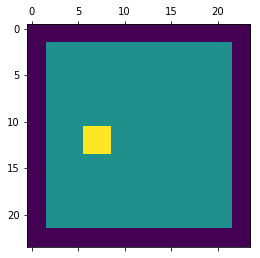

In [4]:
plt.matshow(game.grid.grid)
# plt.savefig('g16h3-map')

## Test with noise  
Pretranining is done with fixed size 15,  training is between 10 to 15, test on 19 

0.5256915032149069


(0.5145754663559762, 0.5368075400738375)

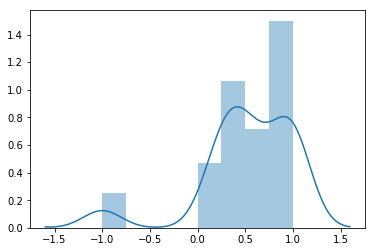

In [10]:
# reward is between -1 to 1, for positive number it means propotion to optimal path,  for - 1 means fail(pass limit)
Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoin0_0_9', inputs_type=(1, 0))   
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_0_9'
Pretest.game.net.load_state_dict(torch.load(weight))
Rewards0, r_matrix0 = Test(Pretest.game, reward_control = 0, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = 0.5)
Rewards1, r_matrix1 = Test(Pretest.game, reward_control = 1, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = 0.5)
sns.distplot(r_matrix0 + r_matrix1)
print (np.mean(r_matrix0 + r_matrix1))
Rewards0, Rewards1

In [21]:
Rewards_0 = []
for e in [0, 0.25, 0.5, 0.75, 1]:
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoin0_0_9', inputs_type=(1, 0))   
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint0_2_9'
    Pretest.game.net.load_state_dict(torch.load(weight))
    Rewards0, r_matrix0 = Test(Pretest.game, reward_control = 0, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards1, r_matrix1 = Test(Pretest.game, reward_control = 1, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards_0.append((Rewards0 + Rewards1)/2)

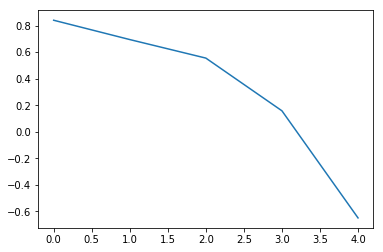

In [8]:
plt.plot(Rewards)

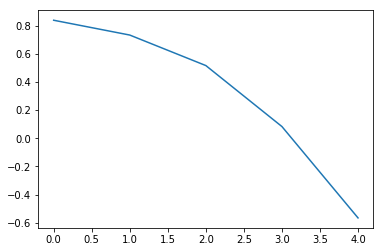

In [4]:
Rewards_1 = []
for e in [0, 0.25, 0.5, 0.75, 1]:
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoin1_0_9', inputs_type=(1, 0))   
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint1_0_9'
    Pretest.game.net.load_state_dict(torch.load(weight))
    Rewards0, r_matrix0 = Test(Pretest.game, reward_control = 0, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards1, r_matrix1 = Test(Pretest.game, reward_control = 1, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards_1.append((Rewards0 + Rewards1)/2)
plt.plot(Rewards_1)

In [10]:
Rewards_39 = []
for e in [0, 0.25, 0.5, 0.75, 1]:
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoin39_0_9', inputs_type=(1, 0))   
    weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_9'
    Pretest.game.net.load_state_dict(torch.load(weight))
    Rewards0, r_matrix0 = Test(Pretest.game, reward_control = 0, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards1, r_matrix1 = Test(Pretest.game, reward_control = 1, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards_39.append((Rewards0 + Rewards1)/2)

In [7]:
Rewards_49 = []
for e in [0, 0.25, 0.5, 0.75, 1]:
    Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights2/rnn_1515tanh512_checkpoin49_2_9', inputs_type=(1, 0))   
    weight = 'weights_fix/weights2/rnn_1515tanh512_checkpoint49_2_9'
    Pretest.loadweight_q(weight, weight)
    Pretest.game.net.load_state_dict(torch.load(weight))
    Rewards0, r_matrix0 = Test(Pretest.game, reward_control = 0, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards1, r_matrix1 = Test(Pretest.game, reward_control = 1, size = 15, test = 0, limit_set = 8, matrix = True, epsilon = e)
    Rewards_49.append((Rewards0 + Rewards1)/2)

([<matplotlib.axis.YTick at 0x7f26587f1b00>,
 <a list of 3 Text yticklabel objects>)

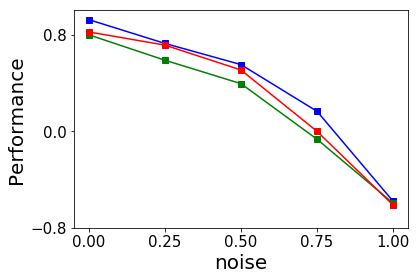

In [22]:
noise =  [0, 0.25, 0.5, 0.75, 1]
plt.plot(noise, Rewards_0, 'bs-')
plt.plot(noise, Rewards_49, 'gs-')
plt.plot(noise, Rewards_39, 'rs-')
plt.ylabel('Performance', size = 20)
plt.xlabel('noise', size = 20)
plt.xticks([0, 0.25, 0.5, 0.75, 1], size = 15)
plt.yticks([-0.8, 0, 0.8], size = 15)

Training from zero seems to be better because it will allow the agent to explore from new

In [12]:
pca = PCA(weight ='weights_fix/weights1/rnn_1515tanh512_checkpoint5_0_9')
pca.pca()

Pretest =  PretrainTest(holes = 0, weight_write = 'weights_fix/weights1/rnn_1515tanh512_checkpoin1_0_9', inputs_type=(1, 0))        

## Test driven action Statistics 

In [38]:
# 2 clicks performance
def Force_action(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[1]) * [dict_a['right']] +  (14-x) * [dict_a['left']]\
        + (16 - start[0]) * [dict_a['down']] + (14-y) * [dict_a['up']]
    elif type_ == 1:
        force_actions = (16 - start[1]) * [dict_a['right']] +  (14-x) * [dict_a['left']] \
        + (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 2:
        force_actions = (start[1] - 2) * [dict_a['left']] +  x * [dict_a['right']] \
        + (16 - start[0]) * [dict_a['down']]  + (14-y) * [dict_a['up']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']] +  x * [dict_a['right']] \
        + (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 4:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (14-y) * [dict_a['up']] \
        + (16 - start[1]) * [dict_a['right']] + (14-x) * [dict_a['left']]
    elif type_ == 5:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (14-y) * [dict_a['up']] \
        + (start[1] - 2) * [dict_a['left']]  + x * [dict_a['right']]
    elif type_ == 6:
        force_actions = (start[0] - 2) * [dict_a['up']] +  y * [dict_a['down']]\
        + (16 - start[1]) * [dict_a['right']]  + (14-x) * [dict_a['left']]
    elif type_ == 7:
        force_actions = (start[0] - 2) * [dict_a['up']] +  y * [dict_a['down']] \
        + (start[1] - 2) * [dict_a['left']]  + x * [dict_a['right']]
    return force_actions

def clicks_count(weight, type_ = 0):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    score_2 = []
    # scan different points
    Score_2 = np.zeros((19, 19))
    for y in np.arange(0, 15, 1):
        for x in np.arange(0, 15, 1):
            score = 0
            for i in range(50):
                start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
#                 force_actions = (size+2-start[1]) * [1] +  x * [3] + (start[0]+1-2) * [0] + 2 * [1] + y * [2]
#                 force_actions2 = (size+2-start[1]) * [1] +  x * [3] + size+1-start[0] * [2] + 2 * [1] + y * [0]
                force_actions = Force_action(x, y, start, type_)
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 0, size = size, test = 0, hidden = hidden,
                                                                        force_actions = force_actions, limit_set = 16)
                start_new = Pos1[len(force_actions)]
                grid = Pretest.game.grid.grid.copy()
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_2.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-len(force_actions)-1
            score = score/50.                                                             
            Score_2[start_new[0], start_new[1]] = score                                                          
    print (np.mean(score_2))
    return score_2, Score_2  


In [6]:
# 1clicks performance
def Force_action_1(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[0]) * [dict_a['down']] +  y * [dict_a['up']]
    elif type_ == 1:
        force_actions = (start[0] - 2) * [dict_a['up']] + y * [dict_a['down']]
    elif type_ == 2:
        force_actions = (16 - start[1]) * [dict_a['right']] + y * [dict_a['left']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']]  + y * [dict_a['right']]
    return force_actions

In [39]:
# 1clicks performance
def Force_action_1(x, y, start, type_):
    dict_a = {'up':0, 'right':1, 'down':2, 'left':3 }
    if type_ == 0:
        force_actions = (16 - start[0]) * [dict_a['down']] +  (16 - start[0]) * [dict_a['up']]
    elif type_ == 1:
        force_actions = (start[0] - 2) * [dict_a['up']] + (start[0] - 2) * [dict_a['down']]
    elif type_ == 2:
        force_actions = (16 - start[1]) * [dict_a['right']] + (16 - start[1]) * [dict_a['left']]
    elif type_ == 3:
        force_actions = (start[1] - 2) * [dict_a['left']]  + (start[1] - 2) * [dict_a['right']]
    return force_actions
# try to compare from each new starting position, what is performance compared to 
# without driven action
def clicks_count_1(weight, type_ = 0):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    # for all points 
    score_1 = []
    # scan different points
    Score_1 = np.zeros((19, 19))
    for y in np.arange(2, 17, 1):
        for x in np.arange(2, 17, 1):
            score = 0
            for i in range(50):
                start = (y, x)
                force_actions = Force_action_1(x, y, start, type_)
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 0, size = size, test = 0\
                                                                         ,force_actions = force_actions, limit_set = 16)
                start_new = Pos1[len(force_actions)]
               
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_1.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-len(force_actions)-1
            score = score/50.                                                             
            Score_1[start_new[0], start_new[1]] = score                                                          
    print (np.mean(score_1))
    return score_1, Score_1  

In [40]:

def zero_click(weight):
    size = 15
    PC_traces = []
    Pretest =  PretrainTest(holes = 0, weight_write = weight, inputs_type=(1, 0)) 
    Pretest.game.net.load_state_dict(torch.load(weight))
    # torch.manual_seed(5)
    hidden = torch.randn(1, 512)
    score_0 = []
    Scores = np.zeros((19, 19))
    for y in np.arange(2, 17, 1):
        for x in np.arange(2, 17, 1):
            score = 0
            for i in range(50):
                start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
                start = (y, x)
                force_actions = []
                Pos1, hidden1, dH1, Action, State1, reward1 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0, hidden = hidden,
                                                                        force_actions = force_actions, limit_set = 16)
            #     Pos2, hidden2, dH2, Action, reward2 = trajectory(Pretest.game, start, reward_control = 1, size = size, test = 0)
                start_new = Pos1[len(force_actions)]
                grid = Pretest.game.grid.grid.copy()
                pos_r = (Pretest.game.pos_reward)
                manhantondist = np.abs(pos_r[0] - start_new[0]) + np.abs(pos_r[1] - start_new[1]) 
                score_0.append(manhantondist/(len(Pos1)-len(force_actions)-1))
                score += len(Pos1)-1
            score = score/50.                                                             
            Scores[start[0], start[1]] = score                                                          
    print (np.mean(score_0))
    return score_0, Scores 

In [41]:
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_5'
Score_0, Scores0_matrix_0 = zero_click(weight)

0.5658934551266361


In [42]:
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_5'
Score_1＿0 = []
Scores1_matrix_0 = np.zeros((4, 19, 19))
for i in range(4):
    score_1, Scores = clicks_count_1(weight, type_ = i)
    Scores1_matrix_0[i] = Scores
    Score_1_0.append(score_1)

0.49698470777454995
0.563937558348051
0.6000501286185178
0.4155520214262029


In [43]:
weight = 'weights_fix/weights1/rnn_1515tanh512_checkpoint39_0_5'
Score_2_0 = []
Scores2_matrix_0 = np.zeros((8, 19, 19))
for i in range(8):
    score_2, Scores = clicks_count(weight, type_ = i)
    Scores2_matrix_0[i] = Scores
    Score_2_0.append(score_2)

0.5845399784209782
0.5588251295397131
0.5737329303970724
0.5719715920646313
0.5960672257205785
0.4620313415719492
0.5867723094596238
0.4637469601888946


(17.77546666666667, 19.715087719298243, 18.851391812865497)

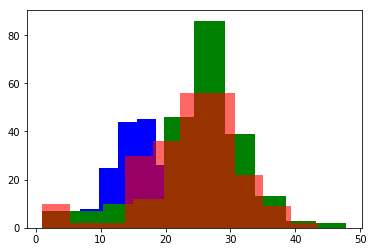

In [20]:
plt.hist(Scores0_matrix_0[2:17, 2:17].ravel(), color = 'b')
plt.hist(np.mean(Scores1_matrix_0[:, 2:17, 2:17], axis = 0).ravel(), color = 'g')
plt.hist(np.mean(Scores2_matrix_0[:, 2:17, 2:17], axis = 0).ravel(), color = 'r', alpha = 0.6)
np.mean(Scores0_matrix_0[2:17, 2:17]), np.mean(Scores1_matrix_0[2:17, 2:17]), np.mean(Scores2_matrix_0[2:17, 2:17])

In [37]:
np.std(Scores1_matrix_0[:, 2:17, 2:17])/np.sqrt(225 * 4)

0.3552457490280061

In [53]:
Score_0_39 = np.load('Scores0_39.npy')
Score_1_39 = np.load('Scores1_39.npy')
Score_2_39 = np.load('Scores2_39.npy')

In [44]:
np.save('Scores0_matrix_shuffle.npy', Scores0_matrix_0)
np.save('Scores1_matrix_shuffle.npy', Scores1_matrix_0)
np.save('Scores2_matrix_shuffle.npy', Scores2_matrix_0)

In [45]:
np.save('Scores0_shuffle.npy', Score_0)
np.save('Scores1_shuffle.npy', Score_1_0)
np.save('Scores2_shuffle.npy', Score_2_0)

In [51]:
len(Score_1_0[0])

11250

([<matplotlib.axis.YTick at 0x7f481483e630>,
 <a list of 3 Text yticklabel objects>)

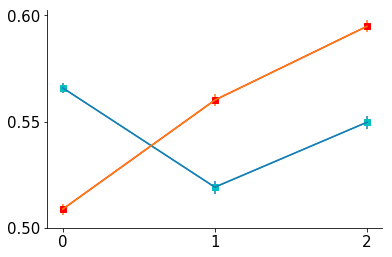

In [57]:
ax = subplot(1, 1, 1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

scores_shuffle = [np.mean(Score_0), np.mean(Score_1_0), np.mean(Score_2_0)]
scores_39 = [np.mean(Score_0_39), np.mean(Score_1_39), np.mean(Score_2_39)]
scores_shuffle_std = [np.std(Score_0), np.std(Score_1_0), np.std(Score_2_0)]
scores_39_std = [np.std(Score_0_39), np.std(Score_1_39), np.std(Score_2_39)]
plt.plot(np.arange(3), scores_shuffle, 'cs-')
plt.plot(np.arange(3), scores_39, 'rs-')
p1 = plt.errorbar(np.arange(3), y =scores_shuffle,  yerr = scores_shuffle_std/np.sqrt(225 * 50))
p1 = plt.errorbar(np.arange(3), y =scores_39,  yerr = scores_39_std/np.sqrt(225 * 50))
plt.xticks([0, 1, 2], size = 15)
plt.yticks([0.5, 0.55, 0.6], size = 15)

([<matplotlib.axis.XTick at 0x7f0dc0debd30>,
 <a list of 3 Text xticklabel objects>)

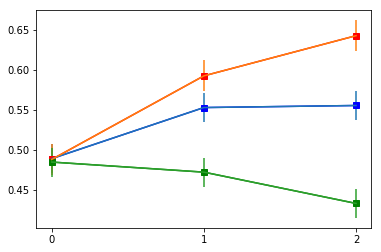

In [316]:
scores_echo = [np.mean(Score_echo_2), np.mean(Score_1_echo_2), np.mean(Score_2_echo_2)]
scores_39 = [np.mean(Score_39), np.mean(Score_1_39), np.mean(Score_2_39)]
scores_49 = [np.mean(Score_49), np.mean(Score_1_49), np.mean(Score_2_49)]
plt.plot(np.arange(3), scores_echo, 'bs-')
plt.plot(np.arange(3), scores_39, 'rs-')
plt.plot(np.arange(3), scores_49, 'gs-')
p1 = plt.errorbar(np.arange(3), scores_echo, yerr=np.std(Score_echo)/np.sqrt(225))
p2 = plt.errorbar(np.arange(3), scores_39, yerr=np.std(Score_39)/np.sqrt(225))
p3 = plt.errorbar(np.arange(3), scores_49, yerr=np.std(Score_49)/np.sqrt(225))
plt.xticks([0, 1, 2])